# Creating CSV Files of Sucrose Activity

This Jupyter notebook compiles all the activities of the rats into 2 dataframes, one for each HFHS diet group (HFHS AdLib, HFHS Restricted). Each dataframe will be sorted by time (with a DateTime index) in **1-second intervals**, for sucrose activity. These dataframes will allow us to:
1. plot time charts to visualize their **average** activities overtime.
2. plot raster plots to also visualize each rat's **individual** activity overtime
3. plot bar graphs to compare each diet group's average feeding activity over **3 phases** (first 2 hours, mid 4 hours, last 2 hours) of the 8-hour window - followed by one-way ANOVA comparing the time phases for each experimental group

*Here is a preview of what the final CSV sheet should look like (example is of the HFHS AdLib group):*

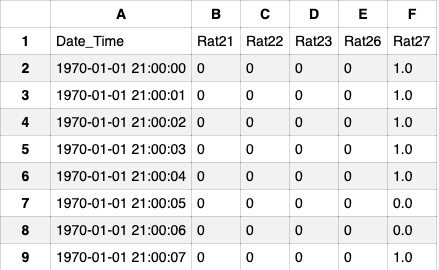

I will create an additional dataframe that shows the average sucrose acitivity for each HFHS group, also sorted by time in **1-second intervals**

*Here is a preview of what this CSV sheet would look like:*

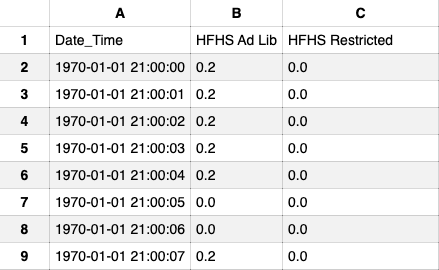

## Import Libraries and Excel Sheets

Begin by running the code below everytime you work with this notebook. The following two cells will merge the activities of all the rats together. **After running this cell, scroll to the cell that imports the CSV files with binary data** The other cells in between are used to create the CSV binary files in the first place.

In [1]:
#----------------------------------------------------------
# Import important libraries
#----------------------------------------------------------
import pandas as pd
import numpy as np
import datetime
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import math 
import matplotlib.gridspec as gridspec

In [2]:
#----------------------------------------------------------
# Set file path to necessary .xlsx files with training and test data
#----------------------------------------------------------
path = "/Users/kushattal/Dropbox/Restriction Feeding/2018 VT experiment/paper/Figures/Data for figures"
files = os.listdir(path)

#----------------------------------------------------------
# Method to collect all the .xlxs files into lists separated by diet and create a dataframe
#----------------------------------------------------------
def get_dataframe(diet_name):
    list_to_fill = [os.path.join(root, name)
             for root, dirs, files in os.walk(path)
             for name in files
             if name.endswith((diet_name + ".xlsx", diet_name + ".xls")) & name.startswith(('Rat'))]
    diet_dataframe = pd.DataFrame()
    for i in list_to_fill:
        df = pd.read_excel(i, index_col = "seconds")
        diet_dataframe = diet_dataframe.append(df)
    diet_dataframe = diet_dataframe.sort_index()
    return diet_dataframe

#----------------------------------------------------------
# Extract all .xlsx files from the list into 4 pandas dataframes - separated by diet
#----------------------------------------------------------
cont_restr_compiled = get_dataframe("Control_Restricted")
hfhs_restr_compiled = get_dataframe("HFHS_Restricted")
cont_adlib_compiled = get_dataframe("Control_Adlib")
hfhs_adlib_compiled = get_dataframe("HFHS_Adlib")
hfhs_restr_compiled.head()

,Subject,Behavior,Status,Time,Hour,Name,seconds.1,Datetime,Act_Time,Real_Time_Hr
seconds,,,,,,,,,,
1970-01-01 00:00:00.000,Rat33_00,Sucrose,START,0.000,0,Rat33,0.000,1969-12-31 19:00:00.000,0:00:00,0.000000
1970-01-01 00:00:00.852,Rat31_00,Feeding,START,0.852,0,Rat31,0.852,1969-12-31 19:00:00.852,0:00:00.852000,0.000237
1970-01-01 00:00:01.602,Rat29_00,Feeding,START,1.602,0,Rat29,1.602,1969-12-31 19:00:01.602,0:00:01.602000,0.000445
1970-01-01 00:00:02.653,Rat32_00,Grooming,START,2.653,0,Rat32,2.653,1969-12-31 19:00:02.653,0:00:02.653000,0.000737
1970-01-01 00:00:03.654,Rat35_00,Feeding,START,3.654,0,Rat35,3.654,1969-12-31 19:00:03.654,0:00:03.654000,0.001015


# Check to make sure all of the behaviors in the "Behavior" column make sense

In [3]:
print(cont_adlib_compiled["Behavior"].unique())
print(hfhs_adlib_compiled["Behavior"].unique())
print(cont_restr_compiled["Behavior"].unique())
print(hfhs_restr_compiled["Behavior"].unique())

['Sleeping/Resting' 'Grooming' 'Feeding' 'Rearing' 'Zoomie' 'Water']
['Sleeping/Resting' 'Grooming' 'Rearing' 'Zoomie' 'Water' 'Sucrose'
 'Feeding']
['Feeding' 'Sleeping/Resting' 'Rearing' 'Zoomie' 'Grooming' 'Water']
['Sucrose' 'Feeding' 'Grooming' 'Rearing' 'Water' 'Zoomie'
 'Sleeping/Resting' ' ']


## Add columns of 1s and 0s for each activity to specify whether a behavior is occurring 
- This will allow you to make graphs based on specific rat behaviors
- You do not need to input anything in this block. Just run it

In [4]:
#----------------------------------------------------------
# Create a copy of the diet dataframe with all the data and add columns logging which activity was performed at each time interval
# A '1' indicates the activity STARTed at that time. 
#----------------------------------------------------------
def add_binary(all_data):
    all_data_copy = all_data.copy()
    behaviors = ['Water', 'Feeding', 'Grooming', 'Rearing', 'Sleeping/Resting', 'Sucrose']
    #Add columns that log which activity was performed (except for Zoomie)
    for i in behaviors:
        #behavior_column = (all_data_copy['Status'] == 'START') & (all_data_copy['Behavior'] == i)
        #all_data_copy[i + "_" + 'Activity'] = behavior_column.astype(int)
        behavior_dataframe = all_data_copy.where(all_data_copy.Behavior == i)
        to_binary_dict = {"START":1, "STOP":0}
        all_data_copy[i + "_" + 'Activity'] = behavior_dataframe["Status"].replace(to_binary_dict)
    #Add column for Zoomie since it uses POINT to notify activity rather than START or STOP
    zoom = (all_data_copy['Status']>= 'POINT') & (all_data_copy['Behavior'] == 'Zoomie')
    all_data_copy['Zoomie_Activity'] = zoom.astype(int)
    
    return all_data_copy

#----------------------------------------------------------
# Create the binary diet dataframes
#----------------------------------------------------------
cont_restr_binary = add_binary(cont_restr_compiled)
hfhs_restr_binary = add_binary(hfhs_restr_compiled)
cont_adlib_binary = add_binary(cont_adlib_compiled)
hfhs_adlib_binary = add_binary(hfhs_adlib_compiled)
hfhs_restr_binary.head(15)

,Subject,Behavior,Status,Time,Hour,Name,seconds.1,Datetime,Act_Time,Real_Time_Hr,Water_Activity,Feeding_Activity,Grooming_Activity,Rearing_Activity,Sleeping/Resting_Activity,Sucrose_Activity,Zoomie_Activity
seconds,,,,,,,,,,,,,,,,,
1970-01-01 00:00:00.000,Rat33_00,Sucrose,START,0.000,0,Rat33,0.000,1969-12-31 19:00:00.000,0:00:00,0.000000,NaN,NaN,NaN,NaN,NaN,1.0,0
1970-01-01 00:00:00.852,Rat31_00,Feeding,START,0.852,0,Rat31,0.852,1969-12-31 19:00:00.852,0:00:00.852000,0.000237,NaN,1.0,NaN,NaN,NaN,NaN,0
1970-01-01 00:00:01.602,Rat29_00,Feeding,START,1.602,0,Rat29,1.602,1969-12-31 19:00:01.602,0:00:01.602000,0.000445,NaN,1.0,NaN,NaN,NaN,NaN,0
1970-01-01 00:00:02.653,Rat32_00,Grooming,START,2.653,0,Rat32,2.653,1969-12-31 19:00:02.653,0:00:02.653000,0.000737,NaN,NaN,1.0,NaN,NaN,NaN,0
1970-01-01 00:00:03.654,Rat35_00,Feeding,START,3.654,0,Rat35,3.654,1969-12-31 19:00:03.654,0:00:03.654000,0.001015,NaN,1.0,NaN,NaN,NaN,NaN,0
1970-01-01 00:00:05.100,Rat36_00,Grooming,START,5.100,0,Rat36,5.100,1969-12-31 19:00:05.100,0:00:05.100000,0.001417,NaN,NaN,1.0,NaN,NaN,NaN,0
1970-01-01 00:00:19.901,Rat33_00,Sucrose,STOP,19.901,0,Rat33,19.901,1969-12-31 19:00:19.901,0:00:19.901000,0.005528,NaN,NaN,NaN,NaN,NaN,0.0,0
1970-01-01 00:00:23.102,Rat30_00,Rearing,START,23.102,0,Rat30,23.102,1969-12-31 19:00:23.102,0:00:23.102000,0.006417,NaN,NaN,NaN,1.0,NaN,NaN,0
1970-01-01 00:00:23.351,Rat36_00,Grooming,STOP,23.351,0,Rat36,23.351,1969-12-31 19:00:23.351,0:00:23.351000,0.006486,NaN,NaN,0.0,NaN,NaN,NaN,0


## Rearrange dataframe for plotting the time intervals of a single activity over 24 hours

### Design a dataframe to analyze time/duration of specific activity for a "normalized" rat

### A normalized rat is the average of all rat activity (excluding NaN values) for every 1-second interval of time
Here, we will create a new dataframe separated by 1-second intervals. Rows will be time indices. Columns will be rat numbers. A "1" in a cell indicates that the rat was drinking sucrose throughout the 1-second interval. In this dataframe, the **duration** of the activity will be recorded. In other words, instead of just putting a '1' for every START (and counting bouts), there will be '1's from START until STOP (indicating duration in seconds). 

If you want the **counts or bouts of sucrose activity** and not duration, set the "counts" parameter in the method call to "True" when you use the method

In [5]:
#----------------------------------------------------------
# Method to design a 1-second bin pivot table ordered by rat Name and showing'duration' of sucrose activity indicated by '1's.
#----------------------------------------------------------
def times(activity_capitalized, all_data_copy, diet, counts = False):
    # Create a dataframe with rows as time indices and columns as rat numbers. Values will be "1" or "0".
    times = all_data_copy.pivot_table(index = 'seconds', columns = ['Name'], values = [activity_capitalized + '_Activity'])
    
    # Round up any non-zero fractions to '1' - there have been cases where 2 activities "START"ed at the exact same time so instead of a "1" for both columns, there was a "0.5" for both. Therefore, we need to round 0.5 up to 1 
    times = np.ceil(times)

    # Forward-fill the empty NaN values for each rat with the '0' or '1' that came before it - THIS WILL CALCULATE THE DURATION OF THE ACTIVITY (if you just want counts, set the "counts" parameter to True when you call the function)
    if counts == False:
        times = times.ffill()
    
    # Backward-fill remaining empty Nan values for each rat with a '0'
    times = times.fillna(0)
    
    # Resample dataframe into 1-second intervals
    if counts == False:
        times = times.resample("1S").ffill()
    else:
        times = times.resample("1S").max()
    
    # Backward-fill remaining empty Nan values for each rat with a '0'
    times = times.fillna(0)
    
    # Convert the dataframe to integers rather than floats
    times = times.astype(int)
    
    ## Actively look into the Excel files, find the hours or intervals not recorded for each rat, and set each of those hours to NaN
    if diet == "Control Adlib":
        times.loc['1970-01-01 08:00:00':'1970-01-01 10:59:59', (activity_capitalized + '_Activity','Rat09')] = np.nan
        times.loc['1970-01-01 19:00:00':'1970-01-01 19:59:59', (activity_capitalized + '_Activity','Rat09')] = np.nan
        
    if diet == "Control Restricted":
        times.loc['1970-01-01 07:00:00':'1970-01-01 07:59:59'] = np.nan
        times.loc['1970-01-01 18:00:00':'1970-01-01 18:59:59'] = np.nan
        times.loc['1970-01-01 23:00:00':'1970-01-01 23:59:59', (activity_capitalized + '_Activity','Rat14')] = np.nan
        times.loc['1970-01-01 23:00:00':'1970-01-01 23:59:59', (activity_capitalized + '_Activity','Rat18')] = np.nan
        
    if diet == "HFHS Adlib":
        times.loc['1970-01-01 14:00:00':'1970-01-01 19:59:59', (activity_capitalized + '_Activity','Rat27')] = np.nan
        # Removed Rat 25 Completely
        #times.loc['1970-01-01 00:00:00.000':'1970-01-01 16:59:59.000', (activity_capitalized + '_Activity','Rat25')] = np.nan
        #times.loc['1970-01-01 18:00:00.000':'1970-01-01 23:59:59.000', (activity_capitalized + '_Activity','Rat25')] = np.nan
    
    #if diet == "HFHS Restricted":
    # Removed Rat 28 Completely
        #times.loc['1970-01-01 00:00:00.000':'1970-01-01 06:59:59.000', (activity_capitalized + '_Activity','Rat28')] = np.nan
    
    # Rearrange the hours so Hour 21 is the first hour
    m = times.index.get_level_values(0) > datetime.datetime(1970, 1, 1, 20, 59, 59)
    idx1 = times.index.get_level_values(0)
    times.index = idx1.where(m, idx1 +  datetime.timedelta(days=1))

    times = times.sort_index()                
    
    # Add 16 extra hours with value of '0' for time-restricted animals - THERE SHOULD BE JUST 0's FOR FEEDING AND SUCROSE ACTIVITY FOR ANYTHING OUTSIDE 8-HOUR INTERVAL
    if diet == "HFHS Restricted" or diet == "Control Restricted":
        dates = ["1970-01-01 21:00:00", "1970-01-01 22:00:00", "1970-01-02 7:00:00", "1970-01-02 8:00:00", "1970-01-02 9:00:00", "1970-01-02 10:00:00", "1970-01-02 11:00:00", "1970-01-02 12:00:00", "1970-01-02 13:00:00", "1970-01-02 14:00:00", "1970-01-02 15:00:00", "1970-01-02 16:00:00", "1970-01-02 17:00:00", "1970-01-02 18:00:00", "1970-01-02 19:00:00", "1970-01-02 20:00:00"]

        for i in dates:
            ts = pd.to_datetime(i, format="%Y-%m-%d %H:%M:%S")
            # Change the number of 0's to the number of rats
            if diet == "HFHS Restricted":
                new_row = pd.DataFrame([[0, 0, 0, 0, 0, 0, 0]], columns = times.columns, index=[ts])
            if diet == "Control Restricted":
                new_row = pd.DataFrame([[0, 0, 0, 0, 0, 0, 0, 0, 0]], columns = times.columns, index=[ts])
            times = pd.concat([times, pd.DataFrame(new_row)], ignore_index=False)
        times = times.sort_index()
    
    
    # Construct a normalized rat by finding the average of activity for all rats at each 1-second interval - Replace Nan values with 0 if any
    times[('','mean')] = times.mean(axis=1).fillna(0)
    
    # Drop duplicate rows based on the time indices
    times = times.loc[~times.index.duplicated(keep='first')]
    
    # Remove multi-level columns
    times.columns = times.columns.get_level_values(1)
    
    # Rename the Index from "Name" to ""
    #times = times.rename_axis("Date_Time", axis="columns")
    times = times.rename_axis(columns = {"Name":""})
        
    return times

#----------------------------------------------------------
# Create the 1-second dataframes
#----------------------------------------------------------
hfhs_restr_sucrose = times('Sucrose', hfhs_restr_binary, "HFHS Restricted")
hfhs_adlib_sucrose = times('Sucrose', hfhs_adlib_binary, "HFHS Adlib")
hfhs_restr_sucrose.head()

,Rat29,Rat30,Rat31,Rat32,Rat33,Rat35,Rat36,mean
1970-01-01 21:00:00,0,0,0,0,0,0,0,0.0
1970-01-01 21:00:01,0,0,0,0,0,0,0,0.0
1970-01-01 21:00:02,0,0,0,0,0,0,0,0.0
1970-01-01 21:00:03,0,0,0,0,0,0,0,0.0
1970-01-01 21:00:04,0,0,0,0,0,0,0,0.0


# Create CSV files with Normalized Data for Drinking Sucrose with 1-Second Intervals

In [6]:
#----------------------------------------------------------
# Create CSV file for Normalized Activity
#----------------------------------------------------------
# Sucrose
normalized_sucrose = pd.DataFrame()
normalized_sucrose = normalized_sucrose.append(hfhs_adlib_sucrose['mean'])
normalized_sucrose = normalized_sucrose.append(hfhs_restr_sucrose['mean'])
sucrose_to_print = normalized_sucrose.T
sucrose_to_print = sucrose_to_print.sort_index().fillna(0)
sucrose_to_print.to_csv('Sucrose_Normalized_Activity.csv', index = True, index_label = "Date_Time", header = ['HFHS Ad Lib', 'HFHS Restricted'], date_format='%Y-%m-%d %H:%M:%S')


# Create CSV files with Binary Data for Sucrose Activity

In [7]:
#----------------------------------------------------------
# Create CSV file for Normalized Activity
#----------------------------------------------------------
# 1-Second Binned CSV Files - Sucrose
hfhs_restr_sucrose.to_csv("Sucrose_HFHS_Restricted_Binary.csv", index = True, columns = hfhs_restr_sucrose.columns[:-1], date_format='%Y-%m-%d %H:%M:%S', index_label = "Date_Time")
hfhs_adlib_sucrose.to_csv("Sucrose_HFHS_AdLib_Binary.csv", index = True, columns = hfhs_adlib_sucrose.columns[:-1], date_format='%Y-%m-%d %H:%M:%S', index_label = "Date_Time")
